## Задачи работы:

Выполнение лабораторной работы предполагает решение следующих задач:
1. Изучить общую схему работы метода обратного распространения ошибки с использованием стохастического градиентного спуска.
2. Вывести математические формулы для вычисления градиентов функции ошибки по параметрам нейронной сети и формул коррекции весов.
3. Загрузить набор данных MNIST, выполнить предобработку изображений и меток, если это необходимо.
4. Реализовать и протестировать метод обратного распространения ошибки для задачи классификации рукописных цифр из набора данных MNIST.

Конфигурация нейронной сети:
1. Входной слой содержит $w \times h$ нейронов, что соответствует разрешению одноканального изображения. Для набора MNIST это составляет $28 \times 28$.
2. Выходной слой содержит $k$ нейронов, что соответствует количеству классов изображений Для задачи классификации рукописных цифр MNIST — 10 классов.
3. Скрытый слой содержит $s$ нейронов (параметр).
4. Параметры метода обучения:
   - Скорость обучения (learning rate)
   - Размер пачки данных (batch size)
   - Количество эпох
5. Функции активации:
   - На скрытом слое — функция ReLU.
   - На выходном слое — функция softmax.
   - Входной слой не содержит функции активации.
6. Функция ошибки — кросс-энтропия. softmax вместе с кросс-энтропией упрощает вывод формул.
7. Контрольные параметры для демонстрации работы нейронной сети:
   - Размер пачки данных: от 8 до 64 изображений (в зависимости от доступного объема памяти).
   - Скорость обучения: 0.1.
   - Количество скрытых нейронов $s$: 300.
   - Количество эпох: 20.

## Проверка целостности данных:


Размер обучающей выборки: (60000, 784) (изображений: 60000)
Размер тестовой выборки: (10000, 784) (изображений: 10000)
Диапазон значений пикселей: [0.00, 1.00]
Классы: [0 1 2 3 4 5 6 7 8 9]


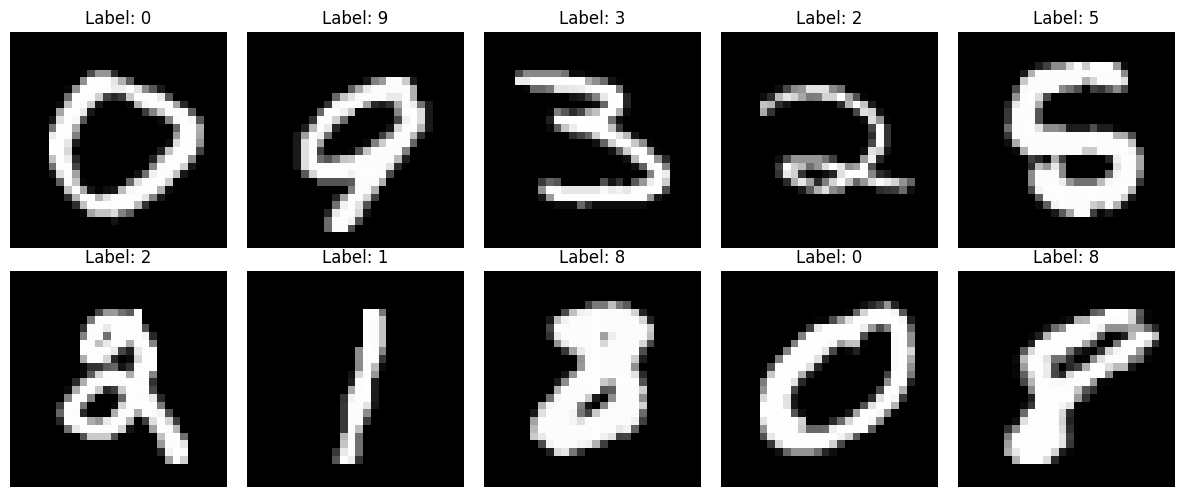

Визуализация 10 случайных изображений:
Размер изображения тренировочного набора: 28 * 28 пикселей
Размер изображения тестового набора: 28 * 28 пикселей
Уникальные метки: [0 1 2 3 4 5 6 7 8 9]

Проверка размерностей:
Форма тренировочного датасета изображений: (60000, 784)
Форма меток тренировочного датасета: (60000,)
Форма тестового набора изображений: (10000, 784)
Форма меток тестового набора: (10000,)
Количество образцов совпадает: True


In [1]:
import numpy as np
import gzip
import time
import matplotlib.pyplot as plt
import os
import urllib.request
import struct

def download_mnist(direc):
    os.makedirs(direc, exist_ok=True)
    base_url = "https://raw.githubusercontent.com/fgnt/mnist/master/"
    files = [
        'train-images-idx3-ubyte.gz',
        'train-labels-idx1-ubyte.gz',
        't10k-images-idx3-ubyte.gz',
        't10k-labels-idx1-ubyte.gz'
    ]
    for file in files:
        full_path = os.path.join(direc, file)
        if not os.path.exists(full_path):
            print(f"Загрузка файла {file}...")
            try:
                urllib.request.urlretrieve(base_url + file, full_path)
                print(f"Файл {file} успешно загружен")
            except Exception as e:
                raise Exception(f"Невозможно скачать файл {file} из внешнего источника: {e}")

def load_mnist_images(direc, filename):
    full_path = os.path.join(direc, filename)
    with gzip.open(full_path, 'rb') as f:
        magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
        data = np.frombuffer(f.read(), np.uint8)
    return data.reshape(-1, 784).astype(float) / 255.0, (rows, cols)

def load_mnist_labels(direc, filename):
    full_path = os.path.join(direc, filename)
    with gzip.open(full_path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

data_dir = 'mnist_data'
download_mnist(data_dir)

X_train, image_shape_train = load_mnist_images(data_dir, 'train-images-idx3-ubyte.gz')
y_train = load_mnist_labels(data_dir, 'train-labels-idx1-ubyte.gz')
X_test, image_shape_test = load_mnist_images(data_dir, 't10k-images-idx3-ubyte.gz')
y_test = load_mnist_labels(data_dir, 't10k-labels-idx1-ubyte.gz')

print("\nРазмер обучающей выборки:", X_train.shape, f"(изображений: {X_train.shape[0]})")
print("Размер тестовой выборки:", X_test.shape, f"(изображений: {X_test.shape[0]})")
print("Диапазон значений пикселей:", f"[{np.min(X_train):.2f}, {np.max(X_train):.2f}]")
print("Классы:", np.unique(y_train))

indices = np.random.choice(len(X_train), 10, replace=False)
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, idx in enumerate(indices):
    row = i // 5
    col = i % 5
    axs[row, col].imshow(X_train[idx].reshape(28, 28), cmap='gray')
    axs[row, col].set_title(f"Label: {y_train[idx]}")
    axs[row, col].axis('off')
plt.tight_layout()
plt.show()

print("Визуализация 10 случайных изображений:")
print(f"Размер изображения тренировочного набора: {image_shape_train[0]} * {image_shape_train[1]} пикселей")
print(f"Размер изображения тестового набора: {image_shape_test[0]} * {image_shape_test[1]} пикселей")
print("Уникальные метки:", np.unique(y_train))

print("\nПроверка размерностей:")
print("Форма тренировочного датасета изображений:", X_train.shape)
print("Форма меток тренировочного датасета:", y_train.shape)
print("Форма тестового набора изображений:", X_test.shape)
print("Форма меток тестового набора:", y_test.shape)
print("Количество образцов совпадает:", X_train.shape[0] == len(y_train))

## Выполнение one-hot кодирования:

In [2]:
def one_hot(y, num_classes=10):
    encoded = np.zeros((len(y), num_classes))
    for i in range(len(y)):
        encoded[i, y[i]] = 1
    return encoded

Y_train = one_hot(y_train)
Y_test = one_hot(y_test)

## Систематизация знаний:

Графическая интерпретация прямого распространения ошибки в первом слое (размер батча принят равным $32$):

$$32\,\underset{X\vphantom{\Big|}}{\left\{ \vphantom{ \begin{array}{c}
\rule{40pt}{0.4pt} \\[2pt]
\rule{40pt}{0.4pt} \\[2pt]
\dots \\
\rule{40pt}{0.4pt}
\end{array} } \right. \kern -2.4pt \overbrace{ \begin{array}{c}
\rule{40pt}{0.4pt} \\[2pt]
\rule{40pt}{0.4pt} \\[2pt]
\dots \\
\rule{40pt}{0.4pt}
\end{array} }^{784}}
\times
784\,\underset{W1\vphantom{\Big|}}{\left\{ \vphantom{ \begin{array}{ccc}
\rule{0.4pt}{40pt} & \rule{0.4pt}{40pt} & \cdots & \rule{0.4pt}{40pt}
\end{array} } \right. \kern -2.4pt \overbrace{ \begin{array}{ccc}
\rule{0.4pt}{40pt} & \rule{0.4pt}{40pt} & \cdots & \rule{0.4pt}{40pt}
\end{array} }^{300}}
+
1\,\underset{b1\vphantom{\Big|}}{\left\{ \vphantom{\Big|}\rule{1pt}{0.4pt} \right. \kern -2.4pt \overbrace{\vphantom{\Big|}\rule{40pt}{0.4pt}}^{300}}
=
32\,\underset{z1\vphantom{\Big|}}{\left\{ \vphantom{ \begin{array}{c}
\rule{40pt}{0.4pt} \\[2pt]
\rule{40pt}{0.4pt} \\[2pt]
\dots \\
\rule{40pt}{0.4pt}
\end{array} } \right. \kern -2.4pt \overbrace{ \begin{array}{c}
\rule{40pt}{0.4pt} \\[2pt]
\rule{40pt}{0.4pt} \\[2pt]
\dots \\
\rule{40pt}{0.4pt}
\end{array} }^{300}}
$$
&nbsp;&nbsp;&nbsp;&nbsp;<small>*Сложение матрицы и вектора-строки возможно благодаря механизму Broadcasting в Python.</small>

Аналитическая запись взвешенной суммы для $j$-го нейрона скрытого слоя:
$$\,z1_j = \sum_{i=1}^{784} x_i \cdot w^{(1)}_{i,j} + b^{(1)}_j, j=1..300$$

&nbsp;&nbsp;&nbsp;&nbsp;<small>*Здесь и далее верхний индекс в скобках $(l)$ над весовыми коэффициентами означает их принадлежность слою $l$ нейронной сети.</small>

Таким образом, в каждой строке матрицы $z1$ находятся неактивированные взвешеные суммы нейронов скрытого слоя, соответствующие одному примеру (изображению) в батче. После применения функции активации ReLU, не меняющей размерность входной матрицы, получаем матрицу $a1$, которая, как и матрица $z1$, имеет форму $(32, 300)$.
Формально эту операцию можно записать следующим образом:
$$a1_{j}=relu(z1_{j}), j=1..300$$

Графическая интерпретация прямого распространения ошибки во втором слое:
$$32\,\underset{a1\vphantom{\Big|}}{\left\{ \vphantom{ \begin{array}{c}
\rule{40pt}{0.4pt} \\[2pt]
\rule{40pt}{0.4pt} \\[2pt]
\dots \\
\rule{40pt}{0.4pt}
\end{array} } \right. \kern -2.4pt \overbrace{ \begin{array}{c}
\rule{40pt}{0.4pt} \\[2pt]
\rule{40pt}{0.4pt} \\[2pt]
\dots \\
\rule{40pt}{0.4pt}
\end{array} }^{300}}
\times
300\,\underset{W2\vphantom{\Big|}}{\left\{ \vphantom{ \begin{array}{ccc}
\rule{0.4pt}{40pt} & \rule{0.4pt}{40pt} & \cdots & \rule{0.4pt}{40pt}
\end{array} } \right. \kern -2.4pt \overbrace{ \begin{array}{ccc}
\rule{0.4pt}{40pt} & \rule{0.4pt}{40pt} & \cdots & \rule{0.4pt}{40pt}
\end{array} }^{10}}
+
1\,\underset{b2\vphantom{\Big|}}{\left\{ \vphantom{\Big|}\rule{1pt}{0.4pt} \right. \kern -2.4pt \overbrace{\vphantom{\Big|}\rule{40pt}{0.4pt}}^{10}}
=
32\,\underset{z2\vphantom{\Big|}}{\left\{ \vphantom{ \begin{array}{c}
\rule{40pt}{0.4pt} \\[2pt]
\rule{40pt}{0.4pt} \\[2pt]
\dots \\
\rule{40pt}{0.4pt}
\end{array} } \right. \kern -2.4pt \overbrace{ \begin{array}{c}
\rule{40pt}{0.4pt} \\[2pt]
\rule{40pt}{0.4pt} \\[2pt]
\dots \\
\rule{40pt}{0.4pt}
\end{array} }^{10}}
$$
Аналитическая запись взвешенной суммы для $j$-го нейрона выходного слоя:
$$z2_j = \sum_{i=1}^{300} a1_i \cdot w^{(2)}_{i,j} + b^{(2)}_j, j=1..10$$

Применяя к каждой строке полученной матрицы $z2$ функцию активации softmax, которая также не меняет размерность входа, получаем распределение вероятностей классов для каждого примера (изображения), находящегося в батче:
$$a2_{j}=softmax(z2_{j}), j=1..10$$

После прямого прохода необходимо вычислить градиенты функции потерь по всем параметрам сети для их последующего обновления. Используем многоклассовую кросс-энтропию в качестве функции потерь:
$$E=-\frac{1}{32}\sum_{m=1}^{32}\sum_{j=1}^{10}y_{m,j}\log(a2_{m,j})$$

Здесь $y_{m,j}$ - истинная метка класса для примера $m$ из батча в one-hot кодировке. Функцию потерь можно записать иначе:
$$E=\frac{1}{32}(E_{1 sample}+E_{2 sample}+...+E_{32 sample})$$

Для упрощения понимания алгоритма backpropagation рассмотрим нахождение градиента по параметрам второго слоя на примере ошибки $E_{1 sample}$. Понятно, что аналитические выражения градиентов для других примеров в батче будут такими же, как и в первом случае.
$$\frac{\partial E_{1 sample}}{\partial w^{(2)}_{i,j}}=\frac{\partial E_{1 sample}}{\partial a2_{j}}\cdot \frac{\partial a2_{j}}{\partial z2_{j}}\cdot \frac{\partial z2_{j}}{\partial w^{(2)}_{i,j}} = (a2_{j}-y_{j})\cdot a1_{i}, j=1..10, i=1..300$$

&nbsp;&nbsp;&nbsp;&nbsp;<small>*Благодаря использованию комбинации softmax и кросс-энтропии производная $\frac{\partial E_{1 sample}}{\partial z2_{j}}$ упрощается до разности между выходом нейроной сети и истинным классом входа.</small>

Графическая интерпретация для всего батча:
$$300\,\underset{a1^T\vphantom{\Big|}}{\left\{ \vphantom{ \begin{array}{ccc}
\rule{0.4pt}{40pt} & \rule{0.4pt}{40pt} & \cdots & \rule{0.4pt}{40pt}
\end{array} } \right. \kern -2.4pt \overbrace{ \begin{array}{ccc}
\rule{0.4pt}{40pt} & \rule{0.4pt}{40pt} & \cdots & \rule{0.4pt}{40pt}
\end{array} }^{32}}
\times
32\,\underset{\frac{\partial E}{\partial z2} \vphantom{\Big|}}{\left\{ \vphantom{ \begin{array}{c}
\rule{40pt}{0.4pt} \\[2pt]
\rule{40pt}{0.4pt} \\[2pt]
\dots \\
\rule{40pt}{0.4pt}
\end{array} } \right. \kern -2.4pt \overbrace{ \begin{array}{c}
\rule{40pt}{0.4pt} \\[2pt]
\rule{40pt}{0.4pt} \\[2pt]
\dots \\
\rule{40pt}{0.4pt}
\end{array} }^{10}}
=
300\,\underset{\frac{\partial E}{\partial W2}\vphantom{\Big|}}{\left\{ \vphantom{ \begin{array}{ccc}
\rule{0.4pt}{40pt} & \rule{0.4pt}{40pt} & \cdots & \rule{0.4pt}{40pt}
\end{array} } \right. \kern -2.4pt \overbrace{ \begin{array}{ccc}
\rule{0.4pt}{40pt} & \rule{0.4pt}{40pt} & \cdots & \rule{0.4pt}{40pt}
\end{array} }^{10}}$$

Матричное умножение $a1^T \times \frac{\partial E}{\partial z2}$ автоматически суммирует вклады всех 32 примеров, а деление (в исходном коде) на размер батча усредняет градиент.

Теперь найдем градиент для смещений второго слоя:
$$\frac{\partial E_{1 sample}}{\partial b^{(2)}_{j}}=\frac{\partial E_{1 sample}}{\partial a2_{j}}\cdot \frac{\partial a2_{j}}{\partial z2_{j}}\cdot \frac{\partial z2_{j}}{\partial b^{(2)}_{j}} = (a2_{j}-y_{j}) \cdot 1 = a2_{j}-y_{j}, j=1..10$$

Для вычисления градиента по всему батчу необходимо найти среднее по стобцам матрицы $\frac{\partial E}{\partial z2}$.

По аналогии рассмотрим нахождение градиента по параметрам первого слоя:
$$\frac{\partial E_{1 sample}}{\partial w^{(1)}_{i,j}}=\sum_{k=1}^{10}\left( \frac{\partial E_{1 sample}}{\partial a2_{k}}\cdot \frac{\partial a2_{k}}{\partial z2_{k}}\cdot \frac{\partial z2_{k}}{\partial a1_{j}} \right)\cdot \frac{\partial a1_{j}}{\partial z1_{j}}\cdot \frac{\partial z1_{j}}{\partial w^{(1)}_{i,j}}, i=1..784, j=1..300$$

$$\frac{\partial E_{1 sample}}{\partial w^{(1)}_{i,j}}=\sum_{k=1}^{10}\left(\left(a2_{k}-y_{k} \right)\cdot w^{(2)}_{j,k}\right)\cdot drelu(z1_{j})\cdot x_{i}$$

&nbsp;&nbsp;&nbsp;&nbsp;<small>*Ошибка от выходного слоя распространяется к $a1_{j}$ через 10 разных путей (по одному от каждого выходного нейрона), поэтому мы суммируем все эти вклады.</small>

Именно по этой причине в графической интерпретации мы используем умножение на транспонированную матрицу весов $W2$:
$$32\,\underset{\frac{\partial E}{\partial z2} \vphantom{\Big|}}{\left\{ \vphantom{ \begin{array}{c}
\rule{40pt}{0.4pt} \\[2pt]
\rule{40pt}{0.4pt} \\[2pt]
\dots \\
\rule{40pt}{0.4pt}
\end{array} } \right. \kern -2.4pt \overbrace{ \begin{array}{c}
\rule{40pt}{0.4pt} \\[2pt]
\rule{40pt}{0.4pt} \\[2pt]
\dots \\
\rule{40pt}{0.4pt}
\end{array} }^{10}}
\times
10\,\underset{W2^T\vphantom{\Big|} \vphantom{\Big|}}{\left\{ \vphantom{ \begin{array}{c}
\rule{40pt}{0.4pt} \\[2pt]
\rule{40pt}{0.4pt} \\[2pt]
\dots \\
\rule{40pt}{0.4pt}
\end{array} } \right. \kern -2.4pt \overbrace{ \begin{array}{c}
\rule{40pt}{0.4pt} \\[2pt]
\rule{40pt}{0.4pt} \\[2pt]
\dots \\
\rule{40pt}{0.4pt}
\end{array} }^{300}}
=
32\,\underset{\frac{\partial E}{\partial a1}\vphantom{\Big|}}{\left\{ \vphantom{ \begin{array}{c}
\rule{40pt}{0.4pt} \\[2pt]
\rule{40pt}{0.4pt} \\[2pt]
\dots \\
\rule{40pt}{0.4pt}
\end{array} } \right. \kern -2.4pt \overbrace{ \begin{array}{c}
\rule{40pt}{0.4pt} \\[2pt]
\rule{40pt}{0.4pt} \\[2pt]
\dots \\
\rule{40pt}{0.4pt}
\end{array} }^{300}}$$

Затем к каждому элементу матрицы $z1$ применяем функцию активации ReLU и результат поэлементно умножаем на матрицу $\frac{\partial E}{\partial a1}$. Обозначим полученную матрицу как $dz1$. Понятно, что выполнение этих операций не приведет к отличию в пространственных размерах матриц-операндов и матриц-результатов.

Для завершения вычисления градиентов по весам первого слоя нужно умножить транспонированный входной батч на матрицу $dz1$:
$$784\,\underset{X^T\vphantom{\Big|}}{\left\{ \vphantom{ \begin{array}{ccc}
\rule{0.4pt}{40pt} & \rule{0.4pt}{40pt} & \cdots & \rule{0.4pt}{40pt}
\end{array} } \right. \kern -2.4pt \overbrace{ \begin{array}{ccc}
\rule{0.4pt}{40pt} & \rule{0.4pt}{40pt} & \cdots & \rule{0.4pt}{40pt}
\end{array} }^{32}}
\times
32\,\underset{dz1 \vphantom{\Big|}}{\left\{ \vphantom{ \begin{array}{c}
\rule{40pt}{0.4pt} \\[2pt]
\rule{40pt}{0.4pt} \\[2pt]
\dots \\
\rule{40pt}{0.4pt}
\end{array} } \right. \kern -2.4pt \overbrace{ \begin{array}{c}
\rule{40pt}{0.4pt} \\[2pt]
\rule{40pt}{0.4pt} \\[2pt]
\dots \\
\rule{40pt}{0.4pt}
\end{array} }^{300}}
=
784\,\underset{\frac{\partial E}{\partial W1}\vphantom{\Big|}}{\left\{ \vphantom{ \begin{array}{ccc}
\rule{0.4pt}{40pt} & \rule{0.4pt}{40pt} & \cdots & \rule{0.4pt}{40pt}
\end{array} } \right. \kern -2.4pt \overbrace{ \begin{array}{ccc}
\rule{0.4pt}{40pt} & \rule{0.4pt}{40pt} & \cdots & \rule{0.4pt}{40pt}
\end{array} }^{300}}$$

Матричное умножение $X^T \times dz1$ автоматически суммирует вклады всех 32 примеров, а деление (в исходном коде) на размер батча усредняет градиент.

Найдем градиент для смещений первого слоя:
$$\frac{\partial E_{1 sample}}{\partial b^{(1)}_{j}}=\sum_{k=1}^{10}\left( \frac{\partial E_{1 sample}}{\partial a2_{k}}\cdot \frac{\partial a2_{k}}{\partial z2_{k}}\cdot \frac{\partial z2_{k}}{\partial a1_{j}} \right)\cdot \frac{\partial a1_{j}}{\partial z1_{j}}\cdot \frac{\partial z1_{j}}{\partial b^{(1)}_{j}}, j=1..300$$

$$\frac{\partial E_{1 sample}}{\partial b^{(1)}_{j}}=\sum_{k=1}^{10}\left(\left(a2_{k}-y_{k} \right)\cdot w^{(2)}_{j,k}\right)\cdot drelu(z1_{j}) \cdot 1$$

Для вычисления градиента по всему батчу необходимо найти среднее по стобцам матрицы $dz1$.

Правило обновления весов для мини-пакетного градиентного спуска:
$$\theta = \theta - \frac{\alpha}{m}\sum_{i=1}^{m}\nabla_{\theta}E(\theta;x^{(i)};y^{(i)})$$

где $x^{(i)}, y^{(i)}$ - входные признаки и метки $i$-го примера в батче, $\nabla_{\theta}E(\theta;x^{(i)};y^{(i)})$ - градиент функции потерь по отношению к параметрам нейронной сети $\theta$ для $i$-го примера.

### Приложение:

Сначала найдем производную $\frac{\partial a2_{i}}{\partial z2_{j}}$. Softmax имеет следующий вид:
$$a2_{i}=\frac{e^{z2_{i}}}{\sum_{k=1}^{10}e^{z2_{k}}}$$

По правилу дифференцирования дроби $f(x)=\frac{g(x)}{h(x)}$, имеем $f'(x)=\frac{g'(x)\cdot h(x) - g(x)\cdot h'(x)}{h(x)^2}$. Здесь $g = e^{z2_{i}}$, $h = \sum_{k=1}^{10}e^{z2_{k}}$.

Числитель:
$$\frac{\partial }{\partial z2_j}(e^{z2_{i}})=e^{z2_{i}}\cdot \frac{\partial z2_{i}}{\partial z2_j}$$

$$\frac{\partial}{\partial z2_j}(e^{z2_i}) = \begin{cases}
e^{z2_i}, & \text{если } i = j \\
0, & \text{если } i \neq j
\end{cases}$$

Знаменатель:
$$\frac{\partial }{\partial z2_j}\left(\sum_{k=1}^{10}e^{z2_{k}}\right)=e^{z2_{j}}$$

Рассмотрим два случая: при $j=i$ и $j \neq i$.

$j=i$:

$$\frac{\partial a2_{i}}{\partial z2_{j}}=\frac{e^{z2_{i}} \cdot \sum_{k=1}^{10}e^{z2_{k}} - e^{z2_{j}} \cdot e^{z2_{i}}}{\left(\sum_{k=1}^{10}e^{z2_{k}}\right)^{2}} = \frac{e^{z2_i}}{\sum_{k=1}^{10} e^{z2_k}} \cdot \frac{\sum_{k=1}^{10} e^{z2_k} - e^{z2_j}}{\sum_{k=1}^{10} e^{z2_k}} = a2_i \cdot (1 - a2_i)$$

$j \neq i$:
$$\frac{\partial a2_i}{\partial z2_j} = \frac{0 \cdot \sum_{k=1}^{10} e^{z2_k} - e^{z2_j} \cdot e^{z2_i}}{\left(\sum_{k=1}^{10} e^{z2_k}\right)^2} = \frac{-e^{z2_j} \cdot e^{z2_i}}{\left(\sum_{k=1}^{10} e^{z2_k}\right)^2} = -\frac{e^{z2_j}}{\sum_{k=1}^{10} e^{z2_k}} \cdot \frac{e^{z2_i}}{\sum_{k=1}^{10} e^{z2_k}} = -a2_i \cdot a2_j$$

Теперь запишем кросс-энтропию для одного примера:
$$E=-\sum_{k=1}^{10}y_{k}\log(a2_{k})$$

$$\frac{\partial E}{\partial z2_i} = \frac{\partial}{\partial z2_i} \left[ -\sum_{k=1}^{10} y_k \log(a2_k) \right] = -\sum_{k=1}^{10} y_k \frac{\partial \log(a2_k)}{\partial z2_i} = -\sum_{k=1}^{10} y_k \cdot \frac{\partial \log(a2_k)}{\partial a2_k} \cdot \frac{\partial a2_k}{\partial z2_i} = -\sum_{k=1}^{10} \frac{y_k}{a2_k} \cdot \frac{\partial a2_k}{\partial z2_i}$$

Разделим сумму на два случая - когда $i = k$ и когда $i \neq k$:
$$\frac{\partial E}{\partial z2_i} = -\left[\frac{y_i}{a2_i} \cdot \frac{da2_i}{dz2_i} + \sum_{k=1, k\neq i}^{10} \frac{y_k}{a2_k} \cdot \frac{da2_k}{dz2_i}\right] = -\frac{y_i}{a2_i} \cdot a2_i(1 - a2_i) - \sum_{k=1, k\neq i}^{10} \frac{y_k}{a2_k} \cdot (-a2_k \cdot a2_i) = $$
$$= -y_i + y_i \cdot a2_i + \sum_{k=1, k\neq i}^{10} y_k \cdot a2_i = a2_i \cdot (y_i + \sum_{k=1, k\neq i}^{10} y_k) - y_i = a2_i \cdot \sum_{k=1}^{10} y_k - y_i = $$
$$= a2_i \cdot 1 - y_i = a2_i - y_i \text{, поскольку } \sum_{k=1}^{10} y_k = 1$$

## Реализация нейронной сети:

In [3]:
def init_params(input_size, hidden_size, output_size):
    std1 = np.sqrt(2. / input_size)
    W1 = np.random.randn(input_size, hidden_size) * std1
    b1 = np.zeros(hidden_size)
    std2 = np.sqrt(2. / hidden_size)
    W2 = np.random.randn(hidden_size, output_size) * std2
    b2 = np.zeros(output_size)
    return W1, b1, W2, b2

def relu(z):
    return np.maximum(0, z)

def relu_deriv(z):
    return (z > 0).astype(float)

def softmax(z):
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-9)) / m

def forward(X, W1, b1, W2, b2):
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)
    return a2, z1, a1, z2

def backprop(X, y_true, a2, z1, a1, W2):
    m = X.shape[0]
    dz2 = a2 - y_true                 #shape - (m, 10)
    dW2 = np.dot(a1.T, dz2) / m       #shape - (300, 10)
    db2 = np.sum(dz2, axis=0) / m     #shape - (1, 10)
    da1 = np.dot(dz2, W2.T)           #shape - (m, 300)
    dz1 = da1 * relu_deriv(z1)        #shape - (m, 300)
    dW1 = np.dot(X.T, dz1) / m        #shape - (784, 300)
    db1 = np.sum(dz1, axis=0) / m     #shape - (1, 300)
    return dW1, db1, dW2, db2

def update(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2
    return W1, b1, W2, b2

def accuracy(X, y, W1, b1, W2, b2):
    a2, _, _, _ = forward(X, W1, b1, W2, b2)
    preds = np.argmax(a2, axis=1)
    acc = np.mean(preds == y)
    return acc

def train(W1, b1, W2, b2, X, Y, y_labels, batch_size, epochs, lr):
    n = X.shape[0]
    for epoch in range(epochs):
        start = time.time()
        perm = np.random.permutation(n)
        X_shuf = X[perm]
        Y_shuf = Y[perm]
        for i in range(0, n, batch_size):
            end = min(i + batch_size, n)
            Xb = X_shuf[i:end]
            Yb = Y_shuf[i:end]
            a2, z1, a1, z2 = forward(Xb, W1, b1, W2, b2)
            dW1, db1, dW2, db2 = backprop(Xb, Yb, a2, z1, a1, W2)
            W1, b1, W2, b2 = update(W1, b1, W2, b2, dW1, db1, dW2, db2, lr)
        a2_train, _, _, _ = forward(X, W1, b1, W2, b2)
        train_acc = accuracy(X, y_labels, W1, b1, W2, b2)
        train_loss = cross_entropy_loss(Y, a2_train)
        elapsed = time.time() - start
        print(f"Epoch {epoch + 1}: Accuracy {train_acc:.4f}, Train loss {train_loss:.4f}, Time {elapsed:.2f}s")
    return W1, b1, W2, b2

input_size = 784
hidden_size = 300
output_size = 10
lr = 0.1
batch_size = 32
epochs = 20

W1, b1, W2, b2 = init_params(input_size, hidden_size, output_size)
W1, b1, W2, b2 = train(W1, b1, W2, b2, X_train, Y_train, y_train, batch_size, epochs, lr)

a2_test, _, _, _ = forward(X_test, W1, b1, W2, b2)
test_acc = accuracy(X_test, y_test, W1, b1, W2, b2)
test_loss = cross_entropy_loss(Y_test, a2_test)
print(f"\nTest accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

Epoch 1: Accuracy 0.9554, Train loss 0.1546, Time 9.34s
Epoch 2: Accuracy 0.9727, Train loss 0.0963, Time 9.69s
Epoch 3: Accuracy 0.9798, Train loss 0.0729, Time 9.83s
Epoch 4: Accuracy 0.9851, Train loss 0.0548, Time 9.64s
Epoch 5: Accuracy 0.9873, Train loss 0.0467, Time 10.47s
Epoch 6: Accuracy 0.9909, Train loss 0.0369, Time 10.84s
Epoch 7: Accuracy 0.9902, Train loss 0.0352, Time 10.24s
Epoch 8: Accuracy 0.9936, Train loss 0.0277, Time 15.40s
Epoch 9: Accuracy 0.9954, Train loss 0.0217, Time 15.86s
Epoch 10: Accuracy 0.9970, Train loss 0.0179, Time 9.76s
Epoch 11: Accuracy 0.9979, Train loss 0.0146, Time 9.92s
Epoch 12: Accuracy 0.9984, Train loss 0.0124, Time 9.76s
Epoch 13: Accuracy 0.9984, Train loss 0.0113, Time 9.68s
Epoch 14: Accuracy 0.9987, Train loss 0.0108, Time 9.76s
Epoch 15: Accuracy 0.9991, Train loss 0.0087, Time 9.51s
Epoch 16: Accuracy 0.9994, Train loss 0.0078, Time 9.76s
Epoch 17: Accuracy 0.9995, Train loss 0.0064, Time 9.92s
Epoch 18: Accuracy 0.9997, Train lo